# Advance topics

## Optimizing selected positions
Could be that our aim is to optimize a specif feature of the molecule instead of the whole chemical structure. From version 1.0.0 of MolDrug the task it is possible. Previously the class `moldrug.utils.Local` could be used as a workaround. However this class only create one population from the seed molecule rather than make a proper optimization on the chemical space.

Now is as easy as works with CReM. In this case we just need to provided the correct CReM parameter and the class `moldrug.utils.GA` will do the job.

Let's begging importing and creating some simple functions.

In [1]:
from moldrug.data import ligands, boxes, receptors
from moldrug import utils, fitness
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import copy, tempfile, os, requests, gzip, shutil
from multiprocessing import cpu_count
from rdkit.Chem import Draw

def drawgrid(mols):
    return Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300,200), useSVG=True)

def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

We will use the same example as the on discussed in Quickstart but with the some minor modifications.

In [2]:
# Creating a temporal directory
tmp_path = tempfile.TemporaryDirectory()
# Creating receptors files
r_x0161_file = os.path.join(tmp_path.name, 'r_x0161.pdbqt')
with open(r_x0161_file, 'w') as r:
    r.write(receptors.r_x0161)

url = "http://www.qsar4u.com/files/cremdb/replacements02_sc2.db.gz"
r = requests.get(url, allow_redirects=True)
crem_dbgz_path = os.path.join(tmp_path.name,'crem.db.gz')
crem_db_path = os.path.join(tmp_path.name,'crem.db')
open(crem_dbgz_path, 'wb').write(r.content)
with gzip.open(crem_dbgz_path, 'rb') as f_in:
    with open(crem_db_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

Let's first take a look on the numeration of the molecule. In this example we want to optimize the carbon atom with index "0" and **do not** touch the rest of the molecule. CReM handles this possibilities in a very friendlily way: with the kwargs: `replace_ids` and `protected_ids` (visit CReM for more information about it). In this case we will use `replace_ids` specifying the atom with index "0" inside of the `mutate_crem_kwargs` of `moldrug.utils.GA`.

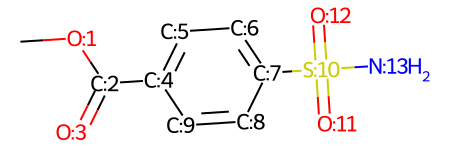

In [3]:
ligand = Chem.MolFromSmiles(ligands.r_x0161)
mol_with_atom_index(copy.deepcopy(ligand))

Initializing `moldrug.utils.GA` 

In [4]:
maxiter = 3
popsize = 20
njobs = 2

out = utils.GA(
    seed_mol=ligand,
    maxiter=maxiter,
    popsize=popsize,
    crem_db_path = crem_db_path,
    pc = 1,
    get_similar = False,
    mutate_crem_kwargs = {
        'radius':3,
        'min_size':0,
        'max_size':0,
        'min_inc':2,
        'max_inc':6,
        'replace_ids':[0],
        'ncores':cpu_count(),
    },
    costfunc = fitness.Cost,
    costfunc_kwargs = {
        'vina_executable': 'vina',
        'receptor_path': r_x0161_file,
        'boxcenter' : boxes.r_x0161["A"]['boxcenter'] ,
        'boxsize': boxes.r_x0161["A"]['boxsize'],
        'exhaustiveness': 4,
        'ncores': int(cpu_count() / njobs),
        'num_modes': 1,
    },
    save_pop_every_gen = 20,
    deffnm = os.path.join(tmp_path.name, 'specific_position'),
    AddHs=True
)

As you can see in the `mutate_crem_kwargs` we are substituting hydrogens atoms by fragments with heavy atoms between 2 and 6; and only will be used for replace the carbon atom with index "0". However, after the first generation and a new fragments is added all the atoms of the new fragments will be considered also for mutations. In other words: `moldrug.utils.GA` will internally update the value of `replace_ids` addding the index of the atoms added by CReM in the previus generation.

In [5]:
out(njobs=njobs)



Creating the first population with 20 members:


100%|██████████| 20/20 [02:09<00:00,  6.49s/it]

Initial Population: Best individual: Individual(idx = 18, smiles = CNC(=O)COC(=O)c1ccc(S(N)(=O)=O)cc1, cost = 0.8945858924023338)
File /tmp/tmpetzyoepy/specific_position_pop.sdf was createad!


Evaluating generation 1 / 3:


100%|██████████| 20/20 [03:54<00:00, 11.70s/it]

Generation 1: Best Individual: Individual(idx = 24, smiles = NC(=O)CNC(=O)COC(=O)c1ccc(S(N)(=O)=O)cc1, cost = 0.8701934560193776).



Evaluating generation 2 / 3:


100%|██████████| 19/19 [02:25<00:00,  7.66s/it]

Generation 2: Best Individual: Individual(idx = 45, smiles = NS(=O)(=O)c1ccc(C(=O)OCC(O)CN2CCOCC2)cc1, cost = 0.7851472166102009).



Evaluating generation 3 / 3:


100%|██████████| 19/19 [03:27<00:00, 10.94s/it]

File /tmp/tmpetzyoepy/specific_position_pop.sdf was createad!
Generation 3: Best Individual: Individual(idx = 77, smiles = CS(=O)(=O)OC(COC(=O)c1ccc(S(N)(=O)=O)cc1)CN1CCOCC1, cost = 0.7814116680249534).


=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

The simulation finished successfully after 3 generations with a population of 20 individuals. A total number of 78 Individuals were seen during the simulation.
Initial Individual: Individual(idx = 0, smiles = COC(=O)c1ccc(S(N)(=O)=O)cc1, cost = 1.0)
Final Individual: Individual(idx = 77, smiles = CS(=O)(=O)OC(COC(=O)c1ccc(S(N)(=O)=O)cc1)CN1CCOCC1, cost = 0.7814116680249534)
The cost function droped in 0.21858833197504657 units.

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

'__call__'  749694.93 ms


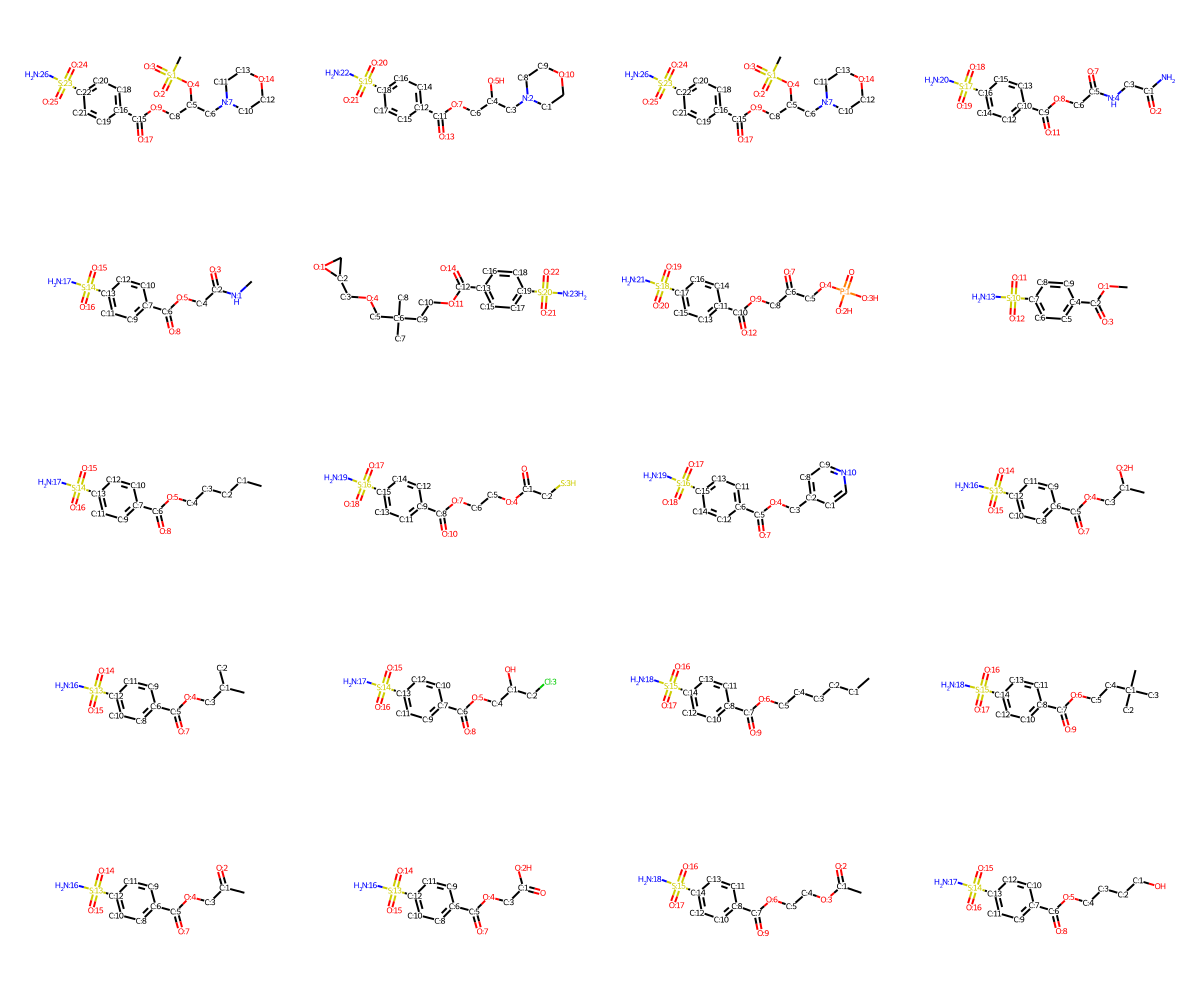

In [6]:
drawgrid([mol_with_atom_index(Chem.RemoveHs(m.mol)) for m in out.pop])

As you can see only the selected atom is the one submitted to modifications. Also, is evident that the numeration sof the molecules are **different**. However this is not a problem for `moldrug.utils.GA`, it is smart enough to identify those changes on numeration during the generations.

**Known issue**: Symmetric molecules! If, for example, we provided the atom index `[5]` instead of `[0]` could be that also the position `9` is submitted to mutation.